# Problem Definition

Given news from the Morrocan online news website, Hespress, what is the topic of that story?


**Translation of topics (from French):**

- **faits divers:** miscellaneous facts          
- **art et culture:** art and culture        
- **regions:** regions               
- **sport:** sport                 
- **medias:** media                
- **economie:** economy              
- **tamazight:** tamazight (the language of the Amazigh people)    
- **societe:** community/company               
- **orbites:** orbits               
- **politique:** policy            
- **marocains du monde:** moroccans-of-the-world

# Imports

In [1]:
!pip install arabic_reshaper

In [2]:
import glob
import math

import pandas as pd
import numpy as np
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns

import arabic_reshaper
from stop_words import get_stop_words
from bidi.algorithm import get_display
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize

# Helper Functions

In [3]:
def remove_stopwords(text,stopwords):
    '''
    Remove Stop Words from text
    Args:
        text: str
        stopwords: set/list/tuple
    Returns:
        The text without stop words
    
    '''
    text_tokens = word_tokenize(text)
    return " ".join([word for word in text_tokens if not word in stopwords])
###################################################################################
def remove_punctuation(text):
    '''
    Remove punctuation from text
    Args:
        text: str
    Returns:
        The text without punctuation
    
    '''
    punctuation = '؛!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = re.sub('[' + re.escape(punctuation) + ']', '', text)
    return text
###################################################################################
def wordcloud_generator(text):
    '''
    Generates word cloud obj
    Args:
        text: str
    Returns:
        The wordcloud
    
    '''
    text = arabic_reshaper.reshape(remove_stopwords(text,stopwords_arabic))
    text = get_display(text)
    return WordCloud(font_path='/kaggle/input/arabicfont/alfont_com_arial-1.ttf', colormap='PuBu').generate(text)
###################################################################################
def top_ngrams(column, n, top_num=10):
    '''
    Returns a Series containing the top ngrams and its frequency
    Args:
        column: Pandas Series
        n: int
        top_num: int
    Returns:
        Top ngrams and frequency: Pandas Series
    
    '''
    # Remove all punctuation, and create a list of words for each example
    story_cleaned = column.str.lower().replace('[^\w\s]', '', regex=True).apply(lambda x: x.split())
    
    # Create the ngrams
    ngrams = story_cleaned.apply(lambda x: list(zip(*[x[i:] for i in range(n)])))
    ngram_counts = ngrams.explode().value_counts()

    # Get top ngrams
    top_ngrams = ngram_counts.head(top_num)  # Change the number to select desired top n-grams
    return top_ngrams

# Load Data

In [4]:
# Get paths of stories only from dir
stories_path = glob.glob("/kaggle/input/hespress/stories_*")

In [5]:
lst = []
for file in stories_path:
    df = pd.read_csv(file, index_col=None, header=0)
    lst.append(df)

stories_data = pd.concat(lst, axis=0, ignore_index=True)

In [6]:
stories_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  11000 non-null  int64 
 1   id          11000 non-null  object
 2   title       11000 non-null  object
 3   date        11000 non-null  object
 4   author      11000 non-null  object
 5   story       11000 non-null  object
 6   topic       11000 non-null  object
dtypes: int64(1), object(6)
memory usage: 601.7+ KB


In [7]:
stories_data.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
# Read stopwords file
file1 = open('/kaggle/input/arabicstopwords/arabic_stopwords_list.txt', 'r', encoding='utf-8') 
stopwords_arabic = file1.read().splitlines()

# Add a new column containing the story with the stopwords removed
stories_data['story_clean'] = stories_data['story'].apply(lambda x: remove_stopwords(x, stopwords_arabic))

In [9]:
# Remove punctuation from text
stories_data['story_clean'] = stories_data['story_clean'].apply(remove_punctuation)

# Exploratory Data Analysis

## Diving into each topic

In [10]:
stories_data.topic.value_counts()

faits-divers          1000
art-et-culture        1000
regions               1000
sport                 1000
medias                1000
economie              1000
tamazight             1000
societe               1000
orbites               1000
politique             1000
marocains-du-monde    1000
Name: topic, dtype: int64

> **For each of the 11 topics, there are 1,000 stories/examples.**

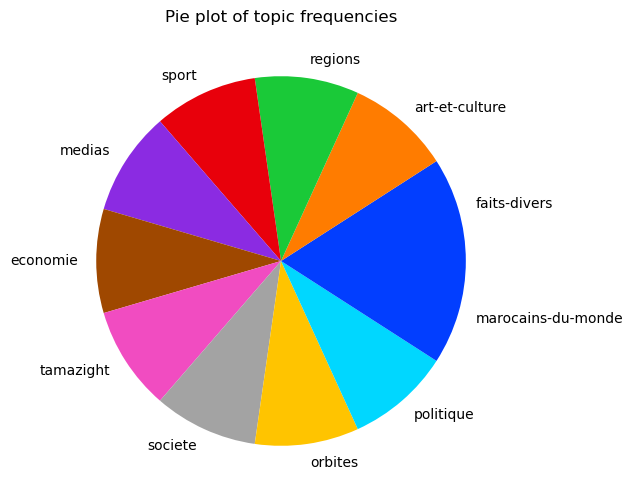

In [11]:
plt.figure(figsize=(6, 6))
plt.title("Pie plot of topic frequencies")
plt.pie(stories_data.topic.value_counts().values, labels = stories_data.topic.value_counts().index, colors = sns.color_palette('bright'))
plt.show()

## Word Cloud

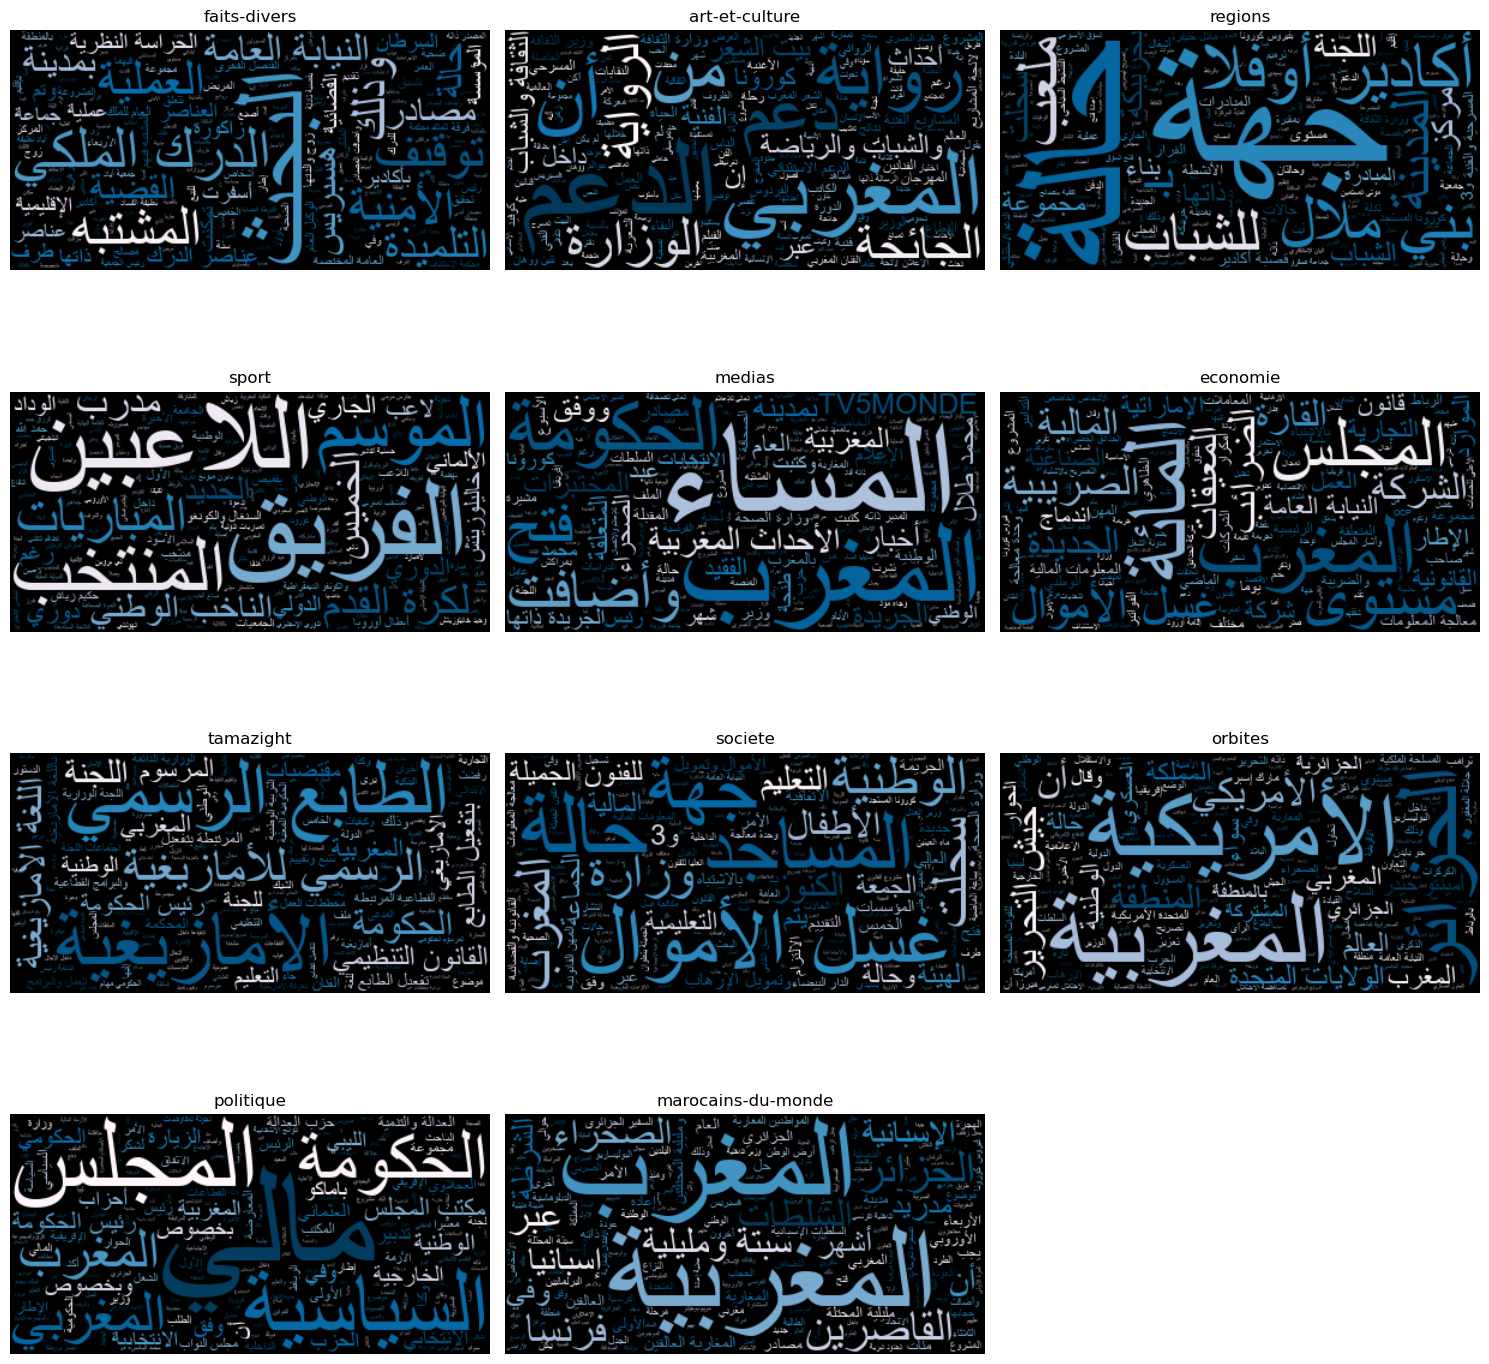

In [12]:
# Plotting the wordcloud

# Calculate the number of rows and columns required
topics = stories_data.topic.unique()
num_images = len(topics)
num_rows = math.ceil(num_images / 3)
num_columns = min(num_images, 3)

# Create a new figure with the desired layout
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over the topics and generate word clouds
for idx, topic in enumerate(topics):
    text = (" ").join(stories_data[stories_data.topic == topic].story.values[:10])
    wc = wordcloud_generator(text)
    
    # Use the corresponding axis for each image
    ax = axes[idx]
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(topic)
    
# Remove any unused axes
for i in range(num_images, num_rows * num_columns):
    fig.delaxes(axes[i])
    
# Adjust the layout
fig.tight_layout()

# Show the figure
plt.show()

## Most repeated words overall

In [13]:
stories_data.head()

,id,title,date,author,story,topic,story_clean
0,9d9ebd0204f811eb92ec646e69d991ea,"شهادة طبيب جراح ""تورط"" قنصلا بتر أصبع مسنة",الجمعة 02 أكتوبر 2020 - 20:08,هسبريس من الدار البيضاء,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...,faits-divers,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...
1,9e96ecc604f811eb836a646e69d991ea,"إحباط تهريب أكثر من طن من ""الحشيش"" بأكادير",الجمعة 02 أكتوبر 2020 - 19:37,رشيد بيجيكن من أكادير,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...,faits-divers,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...
2,9fc1ec4204f811eb8619646e69d991ea,كمين أمن الصويرة يسقط شبكة هجرة غير نظامية,الجمعة 02 أكتوبر 2020 - 18:35,ابراهيم مغراوي من مراكش,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...,faits-divers,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...
3,a0a2fa9c04f811eb8580646e69d991ea,"""تلميذة زاكورة"" تتهم زوج أختها باستغلالها جنسيا",الجمعة 02 أكتوبر 2020 - 14:20,هسبريس من زاكورة,كشف مصدر أمني مسؤول أن التلميذة المتحدرة من جم...,faits-divers,كشف مصدر أمني مسؤول التلميذة المتحدرة جماعة تن...
4,a2d0124a04f811eba88f646e69d991ea,"""أحجار كريمة مزيفة"" تورط أشخاصا بمدينة أكادير",الجمعة 02 أكتوبر 2020 - 10:05,رشيد بيجيكن من أكادير,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...,faits-divers,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...


In [14]:
all_text = ' '.join(stories_data['story_clean'].tolist())
words = all_text.split()
word_counts = Counter(words)
top_10_words = word_counts.most_common(20)

for word, count in top_10_words:
    print(word, count)

المغرب 8892
المغربية 8393
كورونا 6084
الأمازيغية 5513
المغربي 5271
حالة 5173
محمد 5149
رئيس 4578
الحكومة 4576
الوطنية 4477
عبر 4085
الوطني 4027
العام 4005
المغاربة 3985
عبد 3915
أنّ 3622
العامة 3425
بـ 3367
وذلك 3287
وزارة 3275


## Distribution of stories word & character lengths per topic, with and without stopwords

In [15]:
# Get the unique topics
topics = stories_data.topic.unique()

### Word lengths

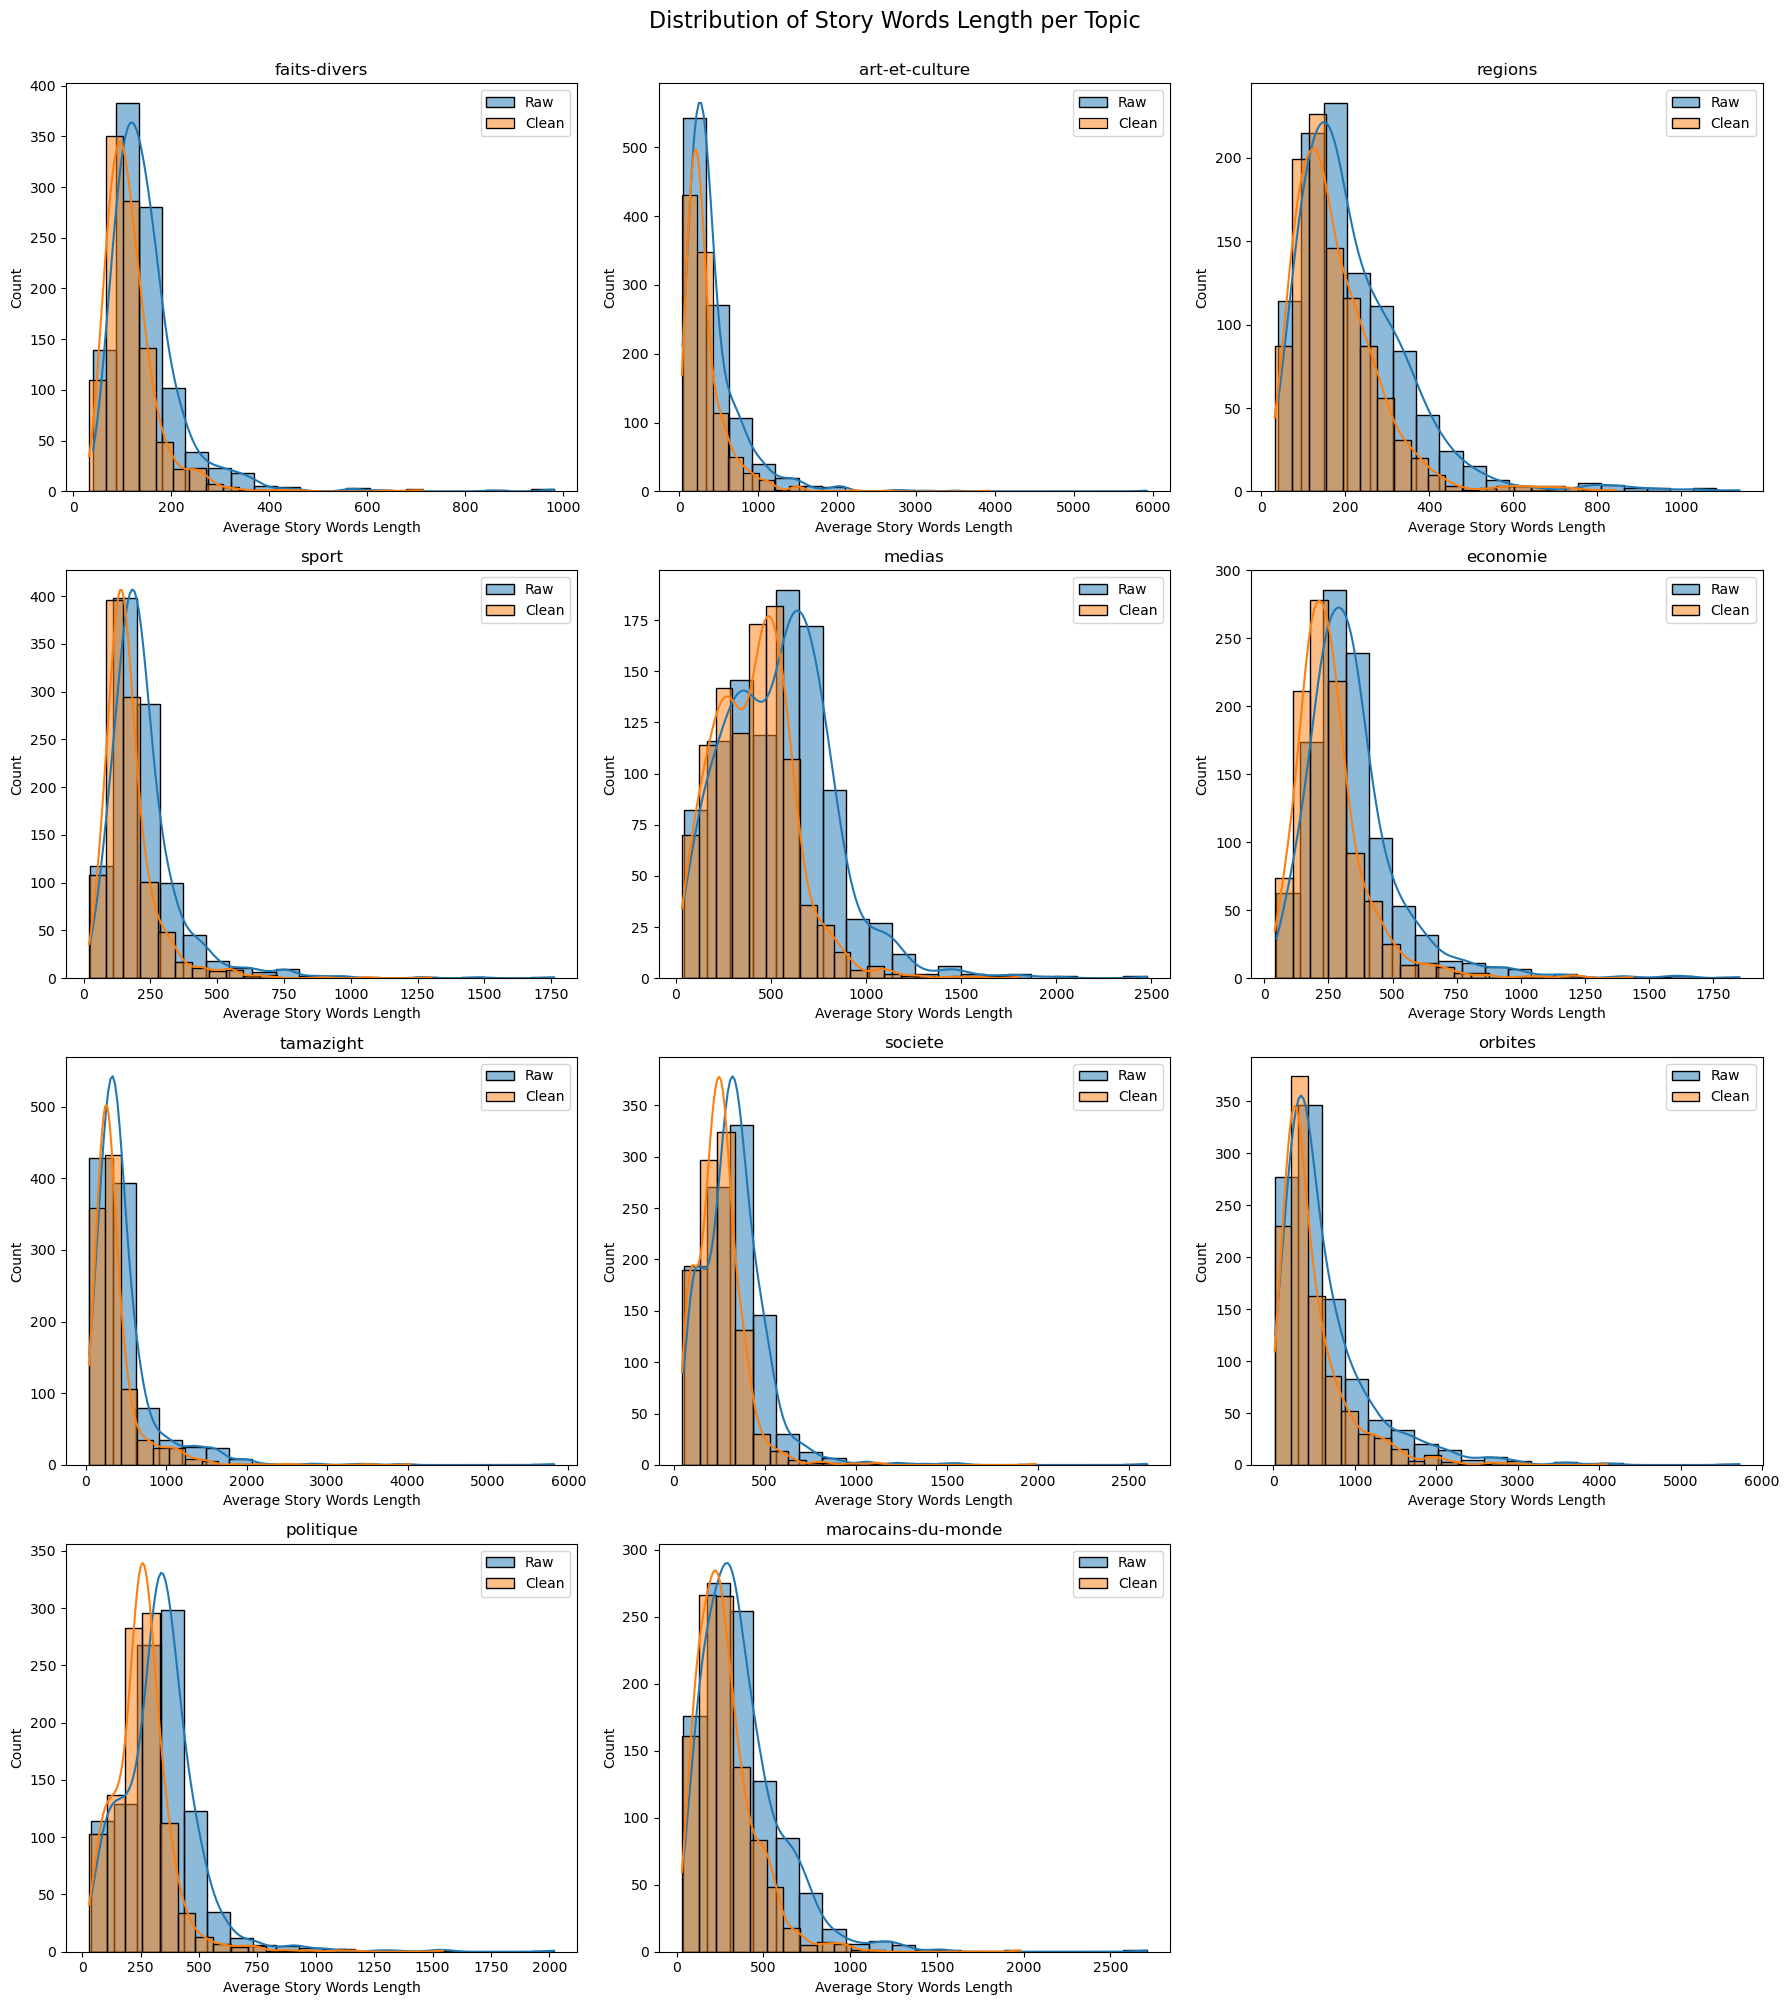

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

# Iterate through each topic and create distplot for clean and unclean stories length
for i, topic in enumerate(topics):
    ax = axes[i]
    
    sns.histplot(stories_data[stories_data['topic']==topic].story.apply(lambda x: len(x.split())), bins=20, label='Raw', ax=ax, kde=True)
    sns.histplot(stories_data[stories_data['topic']==topic].story_clean.apply(lambda x: len(x.split())), bins=20, label='Clean', ax=ax, kde=True)

    ax.set_title(topic)
    ax.set_xlabel('Average Story Words Length')
    ax.legend()

fig.suptitle('Distribution of Story Words Length per Topic', y=1, fontsize=16)
plt.tight_layout()

# Remove unused axes
for i in range(11, 4 * 3):
    fig.delaxes(axes[i])
plt.show()

In [17]:
for topic in topics:
    print(f'{topic}:')
    print('Raw:',stories_data[stories_data['topic']==topic].story.apply(lambda x: len(x.split())).mean())
    print('Clean:',stories_data[stories_data['topic']==topic].story_clean.apply(lambda x: len(x.split())).mean())
    print('----------')

faits-divers:
Raw: 149.244
Clean: 116.874
----------
art-et-culture:
Raw: 426.65
Clean: 326.76
----------
regions:
Raw: 223.271
Clean: 178.562
----------
sport:
Raw: 227.919
Clean: 172.383
----------
medias:
Raw: 545.222
Clean: 411.934
----------
economie:
Raw: 345.076
Clean: 260.306
----------
tamazight:
Raw: 471.819
Clean: 358.137
----------
societe:
Raw: 332.185
Clean: 252.761
----------
orbites:
Raw: 643.044
Clean: 482.465
----------
politique:
Raw: 336.223
Clean: 257.188
----------
marocains-du-monde:
Raw: 374.791
Clean: 283.243
----------


**Highest 2 average word count:**
- **orbites** -> Raw: 643, Clean: 482
- **medias** -> Raw: 545, Clean: 412

**Lowest 2 average word count:**

- **faits-divers** -> Raw: 149, Clean: 117
- **sport** -> Raw: 228, Clean: 172

### Character Lengths

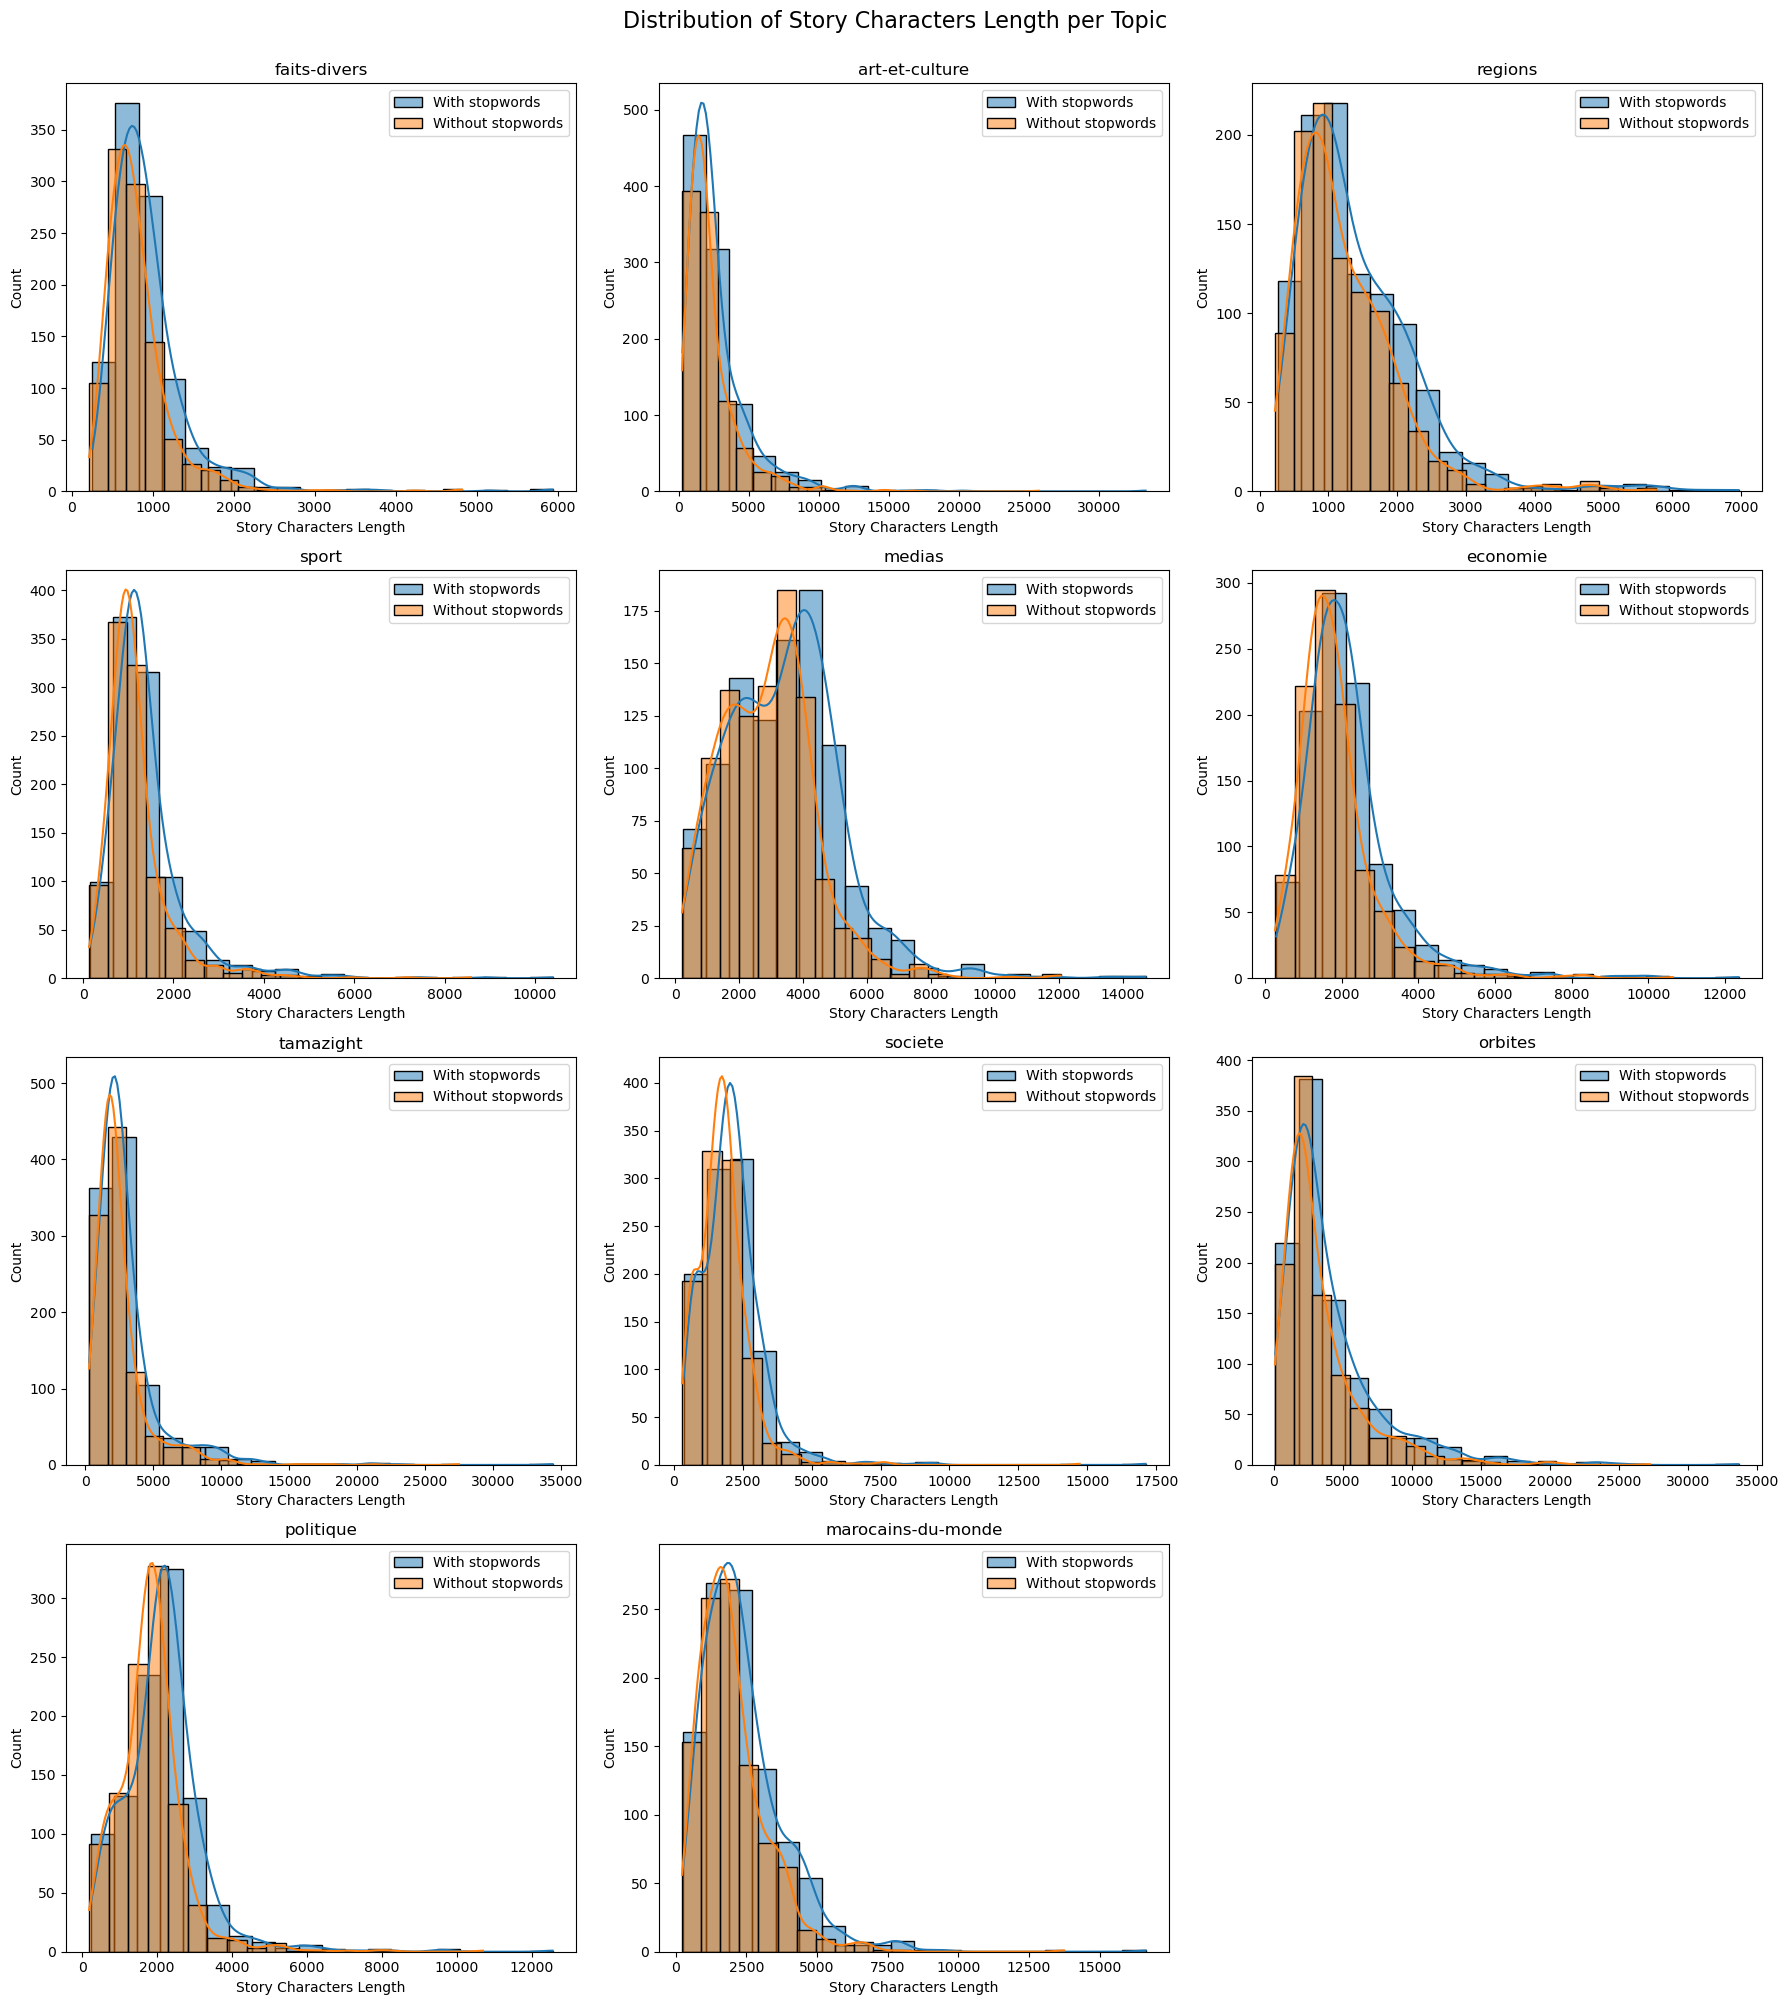

In [18]:
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten()

# Iterate through each topic and create distplot for clean and unclean stories length
for i, topic in enumerate(topics):
    ax = axes[i]
    
    sns.histplot(stories_data[stories_data['topic']==topic].story.apply(len), bins=20, label='With stopwords', ax=ax, kde=True)
    sns.histplot(stories_data[stories_data['topic']==topic].story_clean.apply(len), bins=20, label='Without stopwords', ax=ax, kde=True)

    ax.set_title(topic)
    ax.set_xlabel('Story Characters Length')
    ax.legend()

fig.suptitle('Distribution of Story Characters Length per Topic', y=1, fontsize=16)
plt.tight_layout()

# Remove unused axes
for i in range(11, 4 * 3):
    fig.delaxes(axes[i])
plt.show()

## Most Popular Authors for Each Topic

In [19]:
topics

array(['faits-divers', 'art-et-culture', 'regions', 'sport', 'medias',
       'economie', 'tamazight', 'societe', 'orbites', 'politique',
       'marocains-du-monde'], dtype=object)

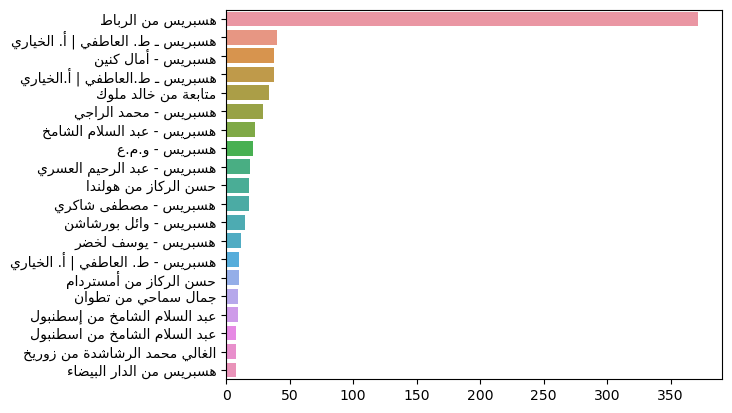

In [20]:
top_author = stories_data[stories_data.topic==topic].author.apply(arabic_reshaper.reshape).apply(get_display).value_counts().index[:20]
top_author_cnt = stories_data[stories_data.topic==topic].author.apply(arabic_reshaper.reshape).apply(get_display).value_counts().values[:20]

sns.barplot(x=top_author_cnt, y=top_author)

ax.set_title(topic)
ax.set_xlabel('Number of Stories')
ax.legend()

In [23]:
ax

<Axes: title={'center': 'politique'}, xlabel='Number of Stories'>

/tmp/ipykernel_32/3968922903.py:17: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  plt.tight_layout()


IndexError: index 11 is out of bounds for axis 0 with size 11

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


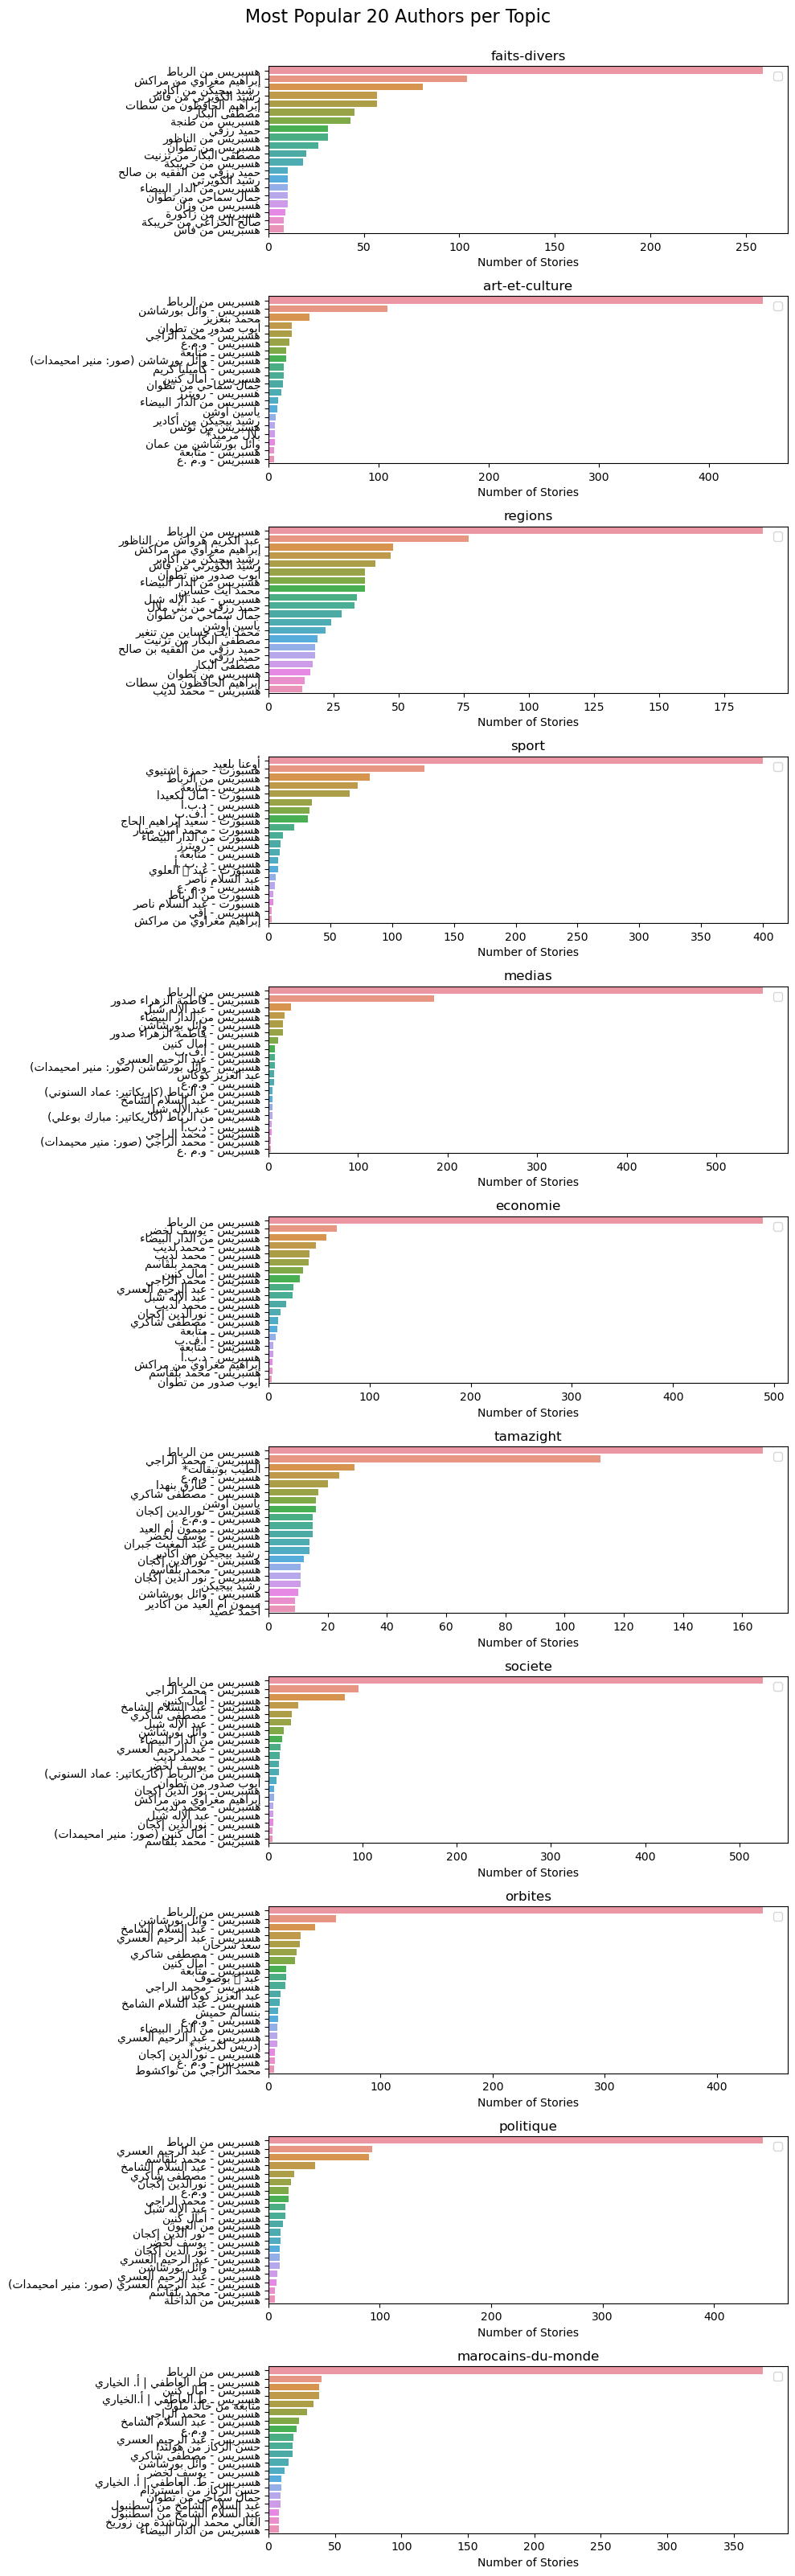

In [29]:
num_rows = (11+ 2) // 3 
fig, axes = plt.subplots(11, 1, figsize=(10, 8 * num_rows))
axes = axes.flatten()

for i, topic in enumerate(topics):
    ax = axes[i]
    top_author = stories_data[stories_data.topic==topic].author.apply(arabic_reshaper.reshape).apply(get_display).value_counts().index[:20]
    top_author_cnt = stories_data[stories_data.topic==topic].author.apply(arabic_reshaper.reshape).apply(get_display).value_counts().values[:20]
    
    sns.barplot(x=top_author_cnt, y=top_author, ax=ax)
    
    ax.set_title(topic)
    ax.set_xlabel('Number of Stories')
    ax.legend()
    
fig.suptitle('Most Popular 20 Authors per Topic', y=1, fontsize=16)
plt.tight_layout()

# Remove unused axes
for i in range(11, 4 * 3):
    fig.delaxes(axes[i])
plt.show();

## Most Frequent N-Grams

### Unigram

In [30]:
for topic in topics:
    print(f'Top 10 frequent unigrams for {topic}')
    print(top_ngrams(stories_data[stories_data['topic']==topic]['story_clean'], 1, 10))
    print('--------------------------------------------------')

Top 10 frequent unigrams for faits-divers
(العامة,)      1037
(عناصر,)        771
(النيابة,)      734
(المشتبه,)      647
(القضائية,)     633
(المختصة,)      600
(البحث,)        555
(بمدينة,)       488
(الشرطة,)       487
(هسبريس,)       476
Name: story_clean, dtype: int64
--------------------------------------------------
Top 10 frequent unigrams for art-et-culture
(المغربي,)     1170
(المغربية,)     973
(أن,)           921
(المغرب,)       833
(محمد,)         826
(عبد,)          698
(الثقافة,)      659
(العربية,)      602
(الفنان,)       599
(الفيلم,)       576
Name: story_clean, dtype: int64
--------------------------------------------------
Top 10 frequent unigrams for regions
(حالة,)       2371
(كورونا,)     1019
(حالات,)       988
(بإقليم,)      921
(السلطات,)     656
(جهة,)         543
(جديدة,)       528
(بفيروس,)      525
(إصابة,)       524
(الصحية,)      515
Name: story_clean, dtype: int64
--------------------------------------------------
Top 10 frequent unigrams for sport
(ال

### Bigrams

In [31]:
for topic in topics:
    print(f'Top 10 frequent bigrams for {topic}')
    print(top_ngrams(stories_data[stories_data['topic']==topic]['story_clean'], 2, 10))
    print('--------------------------------------------------')

Top 10 frequent bigrams for faits-divers
(النيابة, العامة)     730
(العامة, المختصة)     541
(الحراسة, النظرية)    407
(الدرك, الملكي)       344
(تدبير, الحراسة)      239
(إشراف, النيابة)      228
(الشرطة, القضائية)    226
(رهن, إشارة)          215
(مصادر, هسبريس)       213
(إشارة, البحث)        209
Name: story_clean, dtype: int64
--------------------------------------------------
Top 10 frequent bigrams for art-et-culture
(وزارة, الثقافة)        152
(الثقافة, والشباب)      146
(والشباب, والرياضة)     140
(فيروس, كورونا)         135
(التواصل, الاجتماعي)    124
(اللغة, العربية)        115
(محمد, السادس)          111
(الحجر, الصحي)           96
(جائحة, كورونا)          92
(الدار, البيضاء)         90
Name: story_clean, dtype: int64
--------------------------------------------------
Top 10 frequent bigrams for regions
(بفيروس, كورونا)       496
(كورونا, المستجد)      446
(حالة, بإقليم)         352
(الدار, البيضاء)       330
(فيروس, كورونا)        268
(بني, ملال)            252
(المديرية, ا

### Trigrams

In [32]:
for topic in topics:
    print(f'Top 10 frequent trigrams for {topic}')
    print(top_ngrams(stories_data[stories_data['topic']==topic]['story_clean'], 3, 10))
    print('--------------------------------------------------')

Top 10 frequent trigrams for faits-divers
(النيابة, العامة, المختصة)    534
(تدبير, الحراسة, النظرية)     239
(إشراف, النيابة, العامة)      228
(رهن, إشارة, البحث)           209
(الحراسة, النظرية, رهن)       193
(النظرية, رهن, إشارة)         189
(العامة, للأمن, الوطني)       186
(عناصر, الدرك, الملكي)        158
(العامة, المختصة, وذلك)       144
(تشرف, النيابة, العامة)       112
Name: story_clean, dtype: int64
--------------------------------------------------
Top 10 frequent trigrams for art-et-culture
(الثقافة, والشباب, والرياضة)     136
(وزارة, الثقافة, والشباب)         77
(المركز, السينمائي, المغربي)      65
(لجريدة, هسبريس, الإلكترونية)     65
(تصريح, لجريدة, هسبريس)           57
(الدولي, للفيلم, بمراكش)          52
(المؤسسة, الوطنية, للمتاحف)       51
(أكاديمية, المملكة, المغربية)     48
(المهرجان, الدولي, للفيلم)        48
(فيروس, كورونا, المستجد)          47
Name: story_clean, dtype: int64
--------------------------------------------------
Top 10 frequent trigrams for regions
(

## Date Analysis -- For further analysis in the future

In [ ]:
stories_data.date.str.split()

In [ ]:
stories_data['date'].str.split().str[1:4].str.join(' ').str.replace('أكتوبر', 'October')

In [ ]:
stories_data['date'].str.split().str[:3].join(' ')

In [ ]:
date_string = "02 Jul 2020"

pd.to_datetime(date_string)